In [1]:
# =============================================================================
# CELL 1: Library Imports & Environment Setup
# =============================================================================

# Core Python libraries
import itertools
import ssl

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Scikit-learn modules
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

# Fix SSL issues for dataset download (if needed)
ssl._create_default_https_context = ssl._create_unverified_context

print("✅ All dependencies loaded and environment initialized.")
print("-" * 65)


✅ All dependencies loaded and environment initialized.
-----------------------------------------------------------------


In [2]:
# =============================================================================
# CELL 2: Dataset Import & Initial Exploration
# =============================================================================

def fetch_banknote_data():
    """Fetch the Banknote Authentication dataset and prepare train/test splits"""
    dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"

    try:
        # Load without header names
        df = pd.read_csv(dataset_url, header=None)
        print("✅ Dataset retrieved successfully from UCI repository.")
    except Exception as err:
        print("❌ Failed to load dataset:", err)
        return None, None, None, None

    # Assign meaningful column labels
    df.columns = ["variance", "skewness", "curtosis", "entropy", "class"]

    # Dataset summary
    print(f"Shape of dataset: {df.shape}")
    print("Feature columns:", list(df.columns[:-1]))
    print("\nClass distribution:")
    print(df["class"].value_counts().to_string())
    print(f"Authentic notes : {(df['class']==0).sum()}")
    print(f"Forged notes    : {(df['class']==1).sum()}")

    # Split features/target
    X = df.drop(columns=["class"])
    y = df["class"]

    # Split into train/test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, stratify=y, random_state=42
    )

    print("\nTraining set:", X_train.shape, " | Testing set:", X_test.shape)
    print("-" * 65)

    return X_train, X_test, y_train, y_test


# Execute data loader
X_train, X_test, y_train, y_test = fetch_banknote_data()


✅ Dataset retrieved successfully from UCI repository.
Shape of dataset: (1372, 5)
Feature columns: ['variance', 'skewness', 'curtosis', 'entropy']

Class distribution:
class
0    762
1    610
Authentic notes : 762
Forged notes    : 610

Training set: (960, 4)  | Testing set: (412, 4)
-----------------------------------------------------------------


In [3]:
# =============================================================================
# CELL 3: Model Setup + Hyperparameter Grid Definition
# =============================================================================

print("📌 INITIALIZING MODELS AND THEIR SEARCH SPACES")
print("-" * 65)

# Step 1: Instantiate base classifiers
clf_dt   = DecisionTreeClassifier(random_state=42)
clf_knn  = KNeighborsClassifier()
clf_logr = LogisticRegression(random_state=42, max_iter=1000)

# Step 2: Define parameter search grids
# Reminder: dataset has 4 features total
grid_dt = {
    "feature_selection__k": [2, 3, 4],
    "classifier__max_depth": [3, 5, 7, None],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
}

grid_knn = {
    "feature_selection__k": [2, 3, 4],
    "classifier__n_neighbors": [3, 5, 7, 9, 11],
    "classifier__weights": ["uniform", "distance"],
    "classifier__metric": ["euclidean", "manhattan"],
}

grid_logr = {
    "feature_selection__k": [2, 3, 4],
    "classifier__C": [0.1, 1, 10, 100],
    "classifier__penalty": ["l1", "l2"],
    "classifier__solver": ["liblinear"],
}

# Step 3: Bundle into a list for tuning loop
models_with_params = [
    (clf_dt,   grid_dt,   "Decision Tree"),
    (clf_knn,  grid_knn,  "k-Nearest Neighbors"),
    (clf_logr, grid_logr, "Logistic Regression"),
]

print("✅ All models + grids are configured.")
print("Included classifiers:")
for name in ["Decision Tree", "k-Nearest Neighbors", "Logistic Regression"]:
    print(f"   • {name}")
print("-" * 65)


📌 INITIALIZING MODELS AND THEIR SEARCH SPACES
-----------------------------------------------------------------
✅ All models + grids are configured.
Included classifiers:
   • Decision Tree
   • k-Nearest Neighbors
   • Logistic Regression
-----------------------------------------------------------------


In [6]:
# =============================================================================
# Manual Grid Search Function (Updated)
# =============================================================================

def run_manual_grid_search(X_train, y_train, classifiers_to_tune):
    """Run manual grid search implementation"""
    print("MANUAL GRID SEARCH IMPLEMENTATION")
    print("="*60)

    best_estimators = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"\n🔍 Manual Grid Search for {name}")
        print("-" * 40)

        best_score = -1
        best_params = None

        # Adjust parameter grid for dataset size (ensure k <= n_features)
        adjusted_param_grid = param_grid.copy()
        if 'feature_selection__k' in adjusted_param_grid:
            max_k = min(max(adjusted_param_grid['feature_selection__k']), n_features)
            adjusted_param_grid['feature_selection__k'] = [
                k for k in adjusted_param_grid['feature_selection__k'] if k <= max_k
            ]

        # Generate all parameter combinations
        param_names = list(adjusted_param_grid.keys())
        param_values = list(adjusted_param_grid.values())
        all_combinations = list(itertools.product(*param_values))

        print(f"Testing {len(all_combinations)} parameter combinations...")

        # Test each parameter combination
        for i, param_combination in enumerate(all_combinations):
            current_params = dict(zip(param_names, param_combination))
            cv_scores = []

            # 5-fold cross-validation
            for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
                X_train_fold = X_train.iloc[train_idx]
                X_val_fold = X_train.iloc[val_idx]
                y_train_fold = y_train.iloc[train_idx]
                y_val_fold = y_train.iloc[val_idx]

                # Create and configure pipeline
                pipeline = Pipeline([
                    ('scaler', StandardScaler()),
                    ('feature_selection', SelectKBest(f_classif)),
                    ('classifier', classifier_instance.__class__(**classifier_instance.get_params()))
                ])
                pipeline.set_params(**current_params)

                # Fit and evaluate
                pipeline.fit(X_train_fold, y_train_fold)
                y_pred_proba = pipeline.predict_proba(X_val_fold)[:, 1]
                fold_auc = roc_auc_score(y_val_fold, y_pred_proba)
                cv_scores.append(fold_auc)

            # Calculate mean cross-validation score
            mean_cv_score = np.mean(cv_scores)

            # Update best parameters if improved
            if mean_cv_score > best_score:
                best_score = mean_cv_score
                best_params = current_params

            # Progress update
            if (i + 1) % 25 == 0 or i == len(all_combinations) - 1:
                print(f"  Progress: {i + 1}/{len(all_combinations)} | Best AUC so far: {best_score:.4f}")

        # Create final model with best parameters
        final_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif)),
            ('classifier', classifier_instance)
        ])
        final_pipeline.set_params(**best_params)
        final_pipeline.fit(X_train, y_train)

        # Store results
        best_estimators[name] = final_pipeline

        print(f"\n✓ {name} Results:")
        print(f"  Best Parameters: {best_params}")
        print(f"  Best CV AUC: {best_score:.4f}")

    print("\n" + "="*60)
    return best_estimators


# =============================================================================
# Run manual grid search (using models_with_params from CELL 3)
# =============================================================================
manual_best_models = run_manual_grid_search(X_train, y_train, models_with_params)


MANUAL GRID SEARCH IMPLEMENTATION

🔍 Manual Grid Search for Decision Tree
----------------------------------------
Testing 108 parameter combinations...
  Progress: 25/108 | Best AUC so far: 0.9676
  Progress: 50/108 | Best AUC so far: 0.9875
  Progress: 75/108 | Best AUC so far: 0.9889
  Progress: 100/108 | Best AUC so far: 0.9889
  Progress: 108/108 | Best AUC so far: 0.9889

✓ Decision Tree Results:
  Best Parameters: {'feature_selection__k': 3, 'classifier__max_depth': 7, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 2}
  Best CV AUC: 0.9889

🔍 Manual Grid Search for k-Nearest Neighbors
----------------------------------------
Testing 60 parameter combinations...
  Progress: 25/60 | Best AUC so far: 0.9999
  Progress: 50/60 | Best AUC so far: 1.0000
  Progress: 60/60 | Best AUC so far: 1.0000

✓ k-Nearest Neighbors Results:
  Best Parameters: {'feature_selection__k': 3, 'classifier__n_neighbors': 5, 'classifier__weights': 'distance', 'classifier__metric': 'eu

In [10]:
# =============================================================================
# CELL 5: Built-in Grid Search Implementation
# =============================================================================

def run_builtin_grid_search(X_train, y_train, classifiers_to_tune):
    """Run built-in GridSearchCV implementation"""
    print("BUILT-IN GRID SEARCH (GridSearchCV)")
    print("="*60)

    builtin_results = {}
    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"\n🔍 GridSearchCV for {name}")
        print("-" * 40)

        # Adjust parameter grid (avoid k > n_features)
        adjusted_param_grid = param_grid.copy()
        if 'feature_selection__k' in adjusted_param_grid:
            max_k = min(max(adjusted_param_grid['feature_selection__k']), n_features)
            adjusted_param_grid['feature_selection__k'] = [
                k for k in adjusted_param_grid['feature_selection__k'] if k <= max_k
            ]

        # Create pipeline
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif)),
            ('classifier', classifier_instance)
        ])

        # Setup GridSearchCV
        cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(
            pipeline,
            adjusted_param_grid,
            cv=cv_splitter,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=1
        )

        # Fit GridSearchCV
        print("Fitting GridSearchCV...")
        grid_search.fit(X_train, y_train)

        # Store results
        builtin_results[name] = {
            'best_estimator': grid_search.best_estimator_,
            'best_score': grid_search.best_score_,
            'best_params': grid_search.best_params_
        }

        print(f"✓ {name} Results:")
        print(f"  Best Parameters: {grid_search.best_params_}")
        print(f"  Best CV AUC: {grid_search.best_score_:.4f}")

    print("\n" + "="*60)
    return builtin_results


# =============================================================================
# Run built-in grid search (using models_with_params from CELL 3)
# =============================================================================
builtin_results = run_builtin_grid_search(X_train, y_train, models_with_params)
builtin_best_models = {name: results['best_estimator'] for name, results in builtin_results.items()}


BUILT-IN GRID SEARCH (GridSearchCV)

🔍 GridSearchCV for Decision Tree
----------------------------------------
Fitting GridSearchCV...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
✓ Decision Tree Results:
  Best Parameters: {'classifier__max_depth': 7, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'feature_selection__k': 3}
  Best CV AUC: 0.9889

🔍 GridSearchCV for k-Nearest Neighbors
----------------------------------------
Fitting GridSearchCV...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
✓ k-Nearest Neighbors Results:
  Best Parameters: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 5, 'classifier__weights': 'distance', 'feature_selection__k': 3}
  Best CV AUC: 1.0000

🔍 GridSearchCV for Logistic Regression
----------------------------------------
Fitting GridSearchCV...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
✓ Logistic Regression Results:
  Best Parameters: {'classifier__C': 100, '

In [11]:
# =============================================================================
# CELL 6: Model Evaluation Function
# =============================================================================

def evaluate_models(X_train, X_test, y_train, y_test, best_estimators, method_name):
    """Evaluate selected models and show their performance metrics"""
    print(f"\nMODEL EVALUATION - USING {method_name.upper()} APPROACH")
    print("="*65)

    # Evaluate each model separately
    print(f"\n📊 Performance of Individual Models:")
    print("-" * 50)

    model_scores = {}
    for model_name, model in best_estimators.items():
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1_val = f1_score(y_test, y_pred, zero_division=0)
        auc_val = roc_auc_score(y_test, y_pred_proba)

        model_scores[model_name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1': f1_val,
            'AUC': auc_val
        }

        # Print results
        print(f"\n▶ {model_name}:")
        print(f"   - Accuracy : {accuracy:.4f}")
        print(f"   - Precision: {precision:.4f}")
        print(f"   - Recall   : {recall:.4f}")
        print(f"   - F1-Score : {f1_val:.4f}")
        print(f"   - ROC AUC  : {auc_val:.4f}")

    # Voting Classifier (Ensemble)
    print(f"\n🗳️ Combined Voting Classifier Results:")
    print("-" * 50)

    if method_name.lower() == "manual":
        # Manual soft voting
        vote_preds = []
        avg_probas = []

        for idx in range(len(X_test)):
            votes = []
            probas = []
            for m_name, mdl in best_estimators.items():
                pred = mdl.predict(X_test.iloc[[idx]])[0]
                proba = mdl.predict_proba(X_test.iloc[[idx]])[0, 1]
                votes.append(pred)
                probas.append(proba)

            # Majority and average probabilities
            maj_vote = 1 if np.mean(votes) > 0.5 else 0
            mean_proba = np.mean(probas)

            vote_preds.append(maj_vote)
            avg_probas.append(mean_proba)

        vote_preds = np.array(vote_preds)
        avg_probas = np.array(avg_probas)

    else:  # Sklearn VotingClassifier
        est_list = [(m_name, mdl) for m_name, mdl in best_estimators.items()]
        voting_clf = VotingClassifier(estimators=est_list, voting="soft")
        voting_clf.fit(X_train, y_train)

        vote_preds = voting_clf.predict(X_test)
        avg_probas = voting_clf.predict_proba(X_test)[:, 1]

    # Evaluate ensemble
    vote_acc = accuracy_score(y_test, vote_preds)
    vote_prec = precision_score(y_test, vote_preds, zero_division=0)
    vote_rec = recall_score(y_test, vote_preds, zero_division=0)
    vote_f1 = f1_score(y_test, vote_preds, zero_division=0)
    vote_auc = roc_auc_score(y_test, avg_probas)

    print(f"   Accuracy : {vote_acc:.4f}")
    print(f"   Precision: {vote_prec:.4f}")
    print(f"   Recall   : {vote_rec:.4f}")
    print(f"   F1-Score : {vote_f1:.4f}")
    print(f"   ROC AUC  : {vote_auc:.4f}")

    return model_scores, (vote_acc, vote_prec, vote_rec, vote_f1, vote_auc), avg_probas, vote_preds


In [21]:
# ================================
# 🔹 Cell 7: Classifiers to Tune
# ================================
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

classifiers_to_tune = [
    (
        "Decision Tree",
        DecisionTreeClassifier(random_state=42),
        {
            "feature_selection__k": [2, 3, 4],
            "classifier__max_depth": [3, 5, 7, None],
            "classifier__min_samples_split": [2, 5, 10],
            "classifier__min_samples_leaf": [1, 2, 4],
        },
    ),
    (
        "Logistic Regression",
        LogisticRegression(max_iter=500, random_state=42),
        {
            "feature_selection__k": [2, 3, 4],
            "classifier__C": [0.1, 1, 10],
            "classifier__penalty": ["l2"],
            "classifier__solver": ["lbfgs"],
        },
    ),
    (
        "SVM",
        SVC(random_state=42),
        {
            "feature_selection__k": [2, 3, 4],
            "classifier__C": [0.1, 1, 10],
            "classifier__kernel": ["linear", "rbf"],
        },
    ),
]


In [16]:
# =============================================================================
# CELL 8: Manual Grid Search Implementation
# =============================================================================

def run_manual_grid_search(X_train, y_train):
    """Run manual grid search implementation"""
    print("MANUAL GRID SEARCH IMPLEMENTATION")
    print("="*60)

    best_estimators = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    n_features = X_train.shape[1]

    # ✅ Unpack correctly: (name, classifier_instance, param_grid)
    for name, classifier_instance, param_grid in classifiers_to_tune:
        print(f"\n🔍 Manual Grid Search for {name}")
        print("-" * 40)

        best_score = -1
        best_params = None

        # Adjust parameter grid for dataset size
        adjusted_param_grid = param_grid.copy()
        if 'feature_selection__k' in adjusted_param_grid:
            max_k = min(max(adjusted_param_grid['feature_selection__k']), n_features)
            adjusted_param_grid['feature_selection__k'] = [
                k for k in adjusted_param_grid['feature_selection__k'] if k <= max_k
            ]

        # Generate all parameter combinations
        param_names = list(adjusted_param_grid.keys())
        param_values = list(adjusted_param_grid.values())
        all_combinations = list(itertools.product(*param_values))

        print(f"Testing {len(all_combinations)} parameter combinations...")

        # Test each parameter combination
        for i, param_combination in enumerate(all_combinations):
            current_params = dict(zip(param_names, param_combination))
            cv_scores = []

            # 5-fold cross-validation
            for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
                X_train_fold = X_train.iloc[train_idx]
                X_val_fold = X_train.iloc[val_idx]
                y_train_fold = y_train.iloc[train_idx]
                y_val_fold = y_train.iloc[val_idx]

                # Create and configure pipeline
                pipeline = Pipeline([
                    ('scaler', StandardScaler()),
                    ('feature_selection', SelectKBest(f_classif)),
                    ('classifier', classifier_instance.__class__(**classifier_instance.get_params()))
                ])
                pipeline.set_params(**current_params)

                # Fit and evaluate
                pipeline.fit(X_train_fold, y_train_fold)
                y_pred_proba = pipeline.predict_proba(X_val_fold)[:, 1]
                fold_auc = roc_auc_score(y_val_fold, y_pred_proba)
                cv_scores.append(fold_auc)

            # Calculate mean cross-validation score
            mean_cv_score = np.mean(cv_scores)

            # Update best parameters if improved
            if mean_cv_score > best_score:
                best_score = mean_cv_score
                best_params = current_params

            # Progress update
            if (i + 1) % 25 == 0 or i == len(all_combinations) - 1:
                print(f"  Progress: {i + 1}/{len(all_combinations)} | Best AUC: {best_score:.4f}")

        # Create final model with best parameters
        final_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif)),
            ('classifier', classifier_instance)
        ])
        final_pipeline.set_params(**best_params)
        final_pipeline.fit(X_train, y_train)

        # Store results
        best_estimators[name] = final_pipeline

        print(f"\n✓ {name} Results:")
        print(f"  Best Parameters: {best_params}")
        print(f"  Best CV AUC: {best_score:.4f}")

    print("\n" + "="*60)
    return best_estimators

# Run manual grid search
manual_best_models = run_manual_grid_search(X_train, y_train)


MANUAL GRID SEARCH IMPLEMENTATION

🔍 Manual Grid Search for Decision Tree
----------------------------------------
Testing 108 parameter combinations...
  Progress: 25/108 | Best AUC: 0.9676
  Progress: 50/108 | Best AUC: 0.9875
  Progress: 75/108 | Best AUC: 0.9889
  Progress: 100/108 | Best AUC: 0.9889
  Progress: 108/108 | Best AUC: 0.9889

✓ Decision Tree Results:
  Best Parameters: {'feature_selection__k': 3, 'classifier__max_depth': 7, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 2}
  Best CV AUC: 0.9889

🔍 Manual Grid Search for k-NN
----------------------------------------
Testing 48 parameter combinations...
  Progress: 25/48 | Best AUC: 1.0000
  Progress: 48/48 | Best AUC: 1.0000

✓ k-NN Results:
  Best Parameters: {'feature_selection__k': 3, 'classifier__n_neighbors': 5, 'classifier__weights': 'distance', 'classifier__metric': 'euclidean'}
  Best CV AUC: 1.0000

🔍 Manual Grid Search for Logistic Regression
----------------------------------------
Test

In [30]:
# ================================
# Built-in Grid Search Function (Fixed)
# ================================
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

def run_builtin_grid_search(X_train, y_train):
    pipelines = {
        "Decision Tree": Pipeline([
            ("feature_selection", SelectKBest(score_func=f_classif)),
            ("classifier", DecisionTreeClassifier(random_state=42)),
        ]),
        "Logistic Regression": Pipeline([
            ("feature_selection", SelectKBest(score_func=f_classif)),
            ("classifier", LogisticRegression(max_iter=1000, random_state=42)),
        ]),
        "SVM": Pipeline([
            ("feature_selection", SelectKBest(score_func=f_classif)),
            ("classifier", SVC(probability=True, random_state=42)),  # ✅ probability=True for Voting
        ]),
    }

    param_grids = {
        "Decision Tree": {
            "feature_selection__k": [5, 10, "all"],
            "classifier__max_depth": [3, 5, None],
            "classifier__min_samples_split": [2, 5, 10],
        },
        "Logistic Regression": {
            "feature_selection__k": [5, 10, "all"],
            "classifier__C": [0.01, 0.1, 1, 10],
            "classifier__penalty": ["l2"],
            "classifier__solver": ["lbfgs", "liblinear"],
        },
        "SVM": {
            "feature_selection__k": [5, 10, "all"],
            "classifier__C": [0.1, 1, 10],
            "classifier__kernel": ["linear", "rbf"],
        },
    }

    results = {}
    for name, pipeline in pipelines.items():
        print(f"▶ {name} | Grid Search starting...")
        print("-" * 50)

        param_grid = param_grids[name].copy()

        # ✅ Replace "all" with actual number of features
        if "feature_selection__k" in param_grid:
            updated_grid = []
            for k in param_grid["feature_selection__k"]:
                if k == "all":
                    updated_grid.append(X_train.shape[1])
                else:
                    updated_grid.append(k)
            param_grid["feature_selection__k"] = updated_grid

        grid = GridSearchCV(
            pipeline,
            param_grid,
            cv=5,
            scoring="accuracy",
            n_jobs=-1,
            error_score="raise"  # ✅ will show real errors if any remain
        )
        grid.fit(X_train, y_train)

        results[name] = {
            "best_estimator": grid.best_estimator_,
            "best_params": grid.best_params_,
            "best_score": grid.best_score_
        }

        print(f"Best Score for {name}: {grid.best_score_:.4f}")
        print(f"Best Params for {name}: {grid.best_params_}")
        print("=" * 60)

    return results

# ================================
# Run Built-in Grid Search
# ================================
builtin_results = run_builtin_grid_search(X_train, y_train)
builtin_best_models = {name: results["best_estimator"] for name, results in builtin_results.items()}


▶ Decision Tree | Grid Search starting...
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=5 is greater than n_features=4. All the features will be returned.
  warnings.warn(


Best Score for Decision Tree: 0.9865
Best Params for Decision Tree: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'feature_selection__k': 5}
▶ Logistic Regression | Grid Search starting...
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=5 is greater than n_features=4. All the features will be returned.
  warnings.warn(


Best Score for Logistic Regression: 0.9917
Best Params for Logistic Regression: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'feature_selection__k': 5}
▶ SVM | Grid Search starting...
--------------------------------------------------
Best Score for SVM: 1.0000
Best Params for SVM: {'classifier__C': 10, 'classifier__kernel': 'rbf', 'feature_selection__k': 5}


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=5 is greater than n_features=4. All the features will be returned.
  warnings.warn(


In [31]:
# =============================================================================
# CELL 10: Model Evaluation
# =============================================================================

def evaluate_models(X_train, X_test, y_train, y_test, best_estimators, method_name):
    """Evaluate models and create visualizations"""
    print(f"\nMODEL EVALUATION - {method_name.upper()} METHOD")
    print("="*60)

    # Individual model evaluation
    print(f"\n📊 Individual Model Performance:")
    print("-" * 40)

    individual_results = {}
    for name, model in best_estimators.items():
        y_pred = model.predict(X_test)

        # Handle probability/decision_function gracefully
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, "decision_function"):
            scores = model.decision_function(X_test)
            y_pred_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)  # scale to [0,1]
        else:
            y_pred_proba = np.full_like(y_pred, 0.5, dtype=float)

        # Calculate metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc = roc_auc_score(y_test, y_pred_proba)

        individual_results[name] = {
            'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1, 'AUC': auc
        }

        print(f"\n{name}:")
        print(f"  Accuracy:  {acc:.4f}")
        print(f"  Precision: {prec:.4f}")
        print(f"  Recall:    {rec:.4f}")
        print(f"  F1-Score:  {f1:.4f}")
        print(f"  ROC AUC:   {auc:.4f}")

    # Voting Classifier Implementation
    print(f"\n🗳️  Voting Classifier Performance:")
    print("-" * 40)

    if method_name == "Manual":
        # Manual voting implementation
        y_pred_votes = []
        y_pred_proba_avg = []

        for i in range(len(X_test)):
            votes = []
            probas = []

            for name, model in best_estimators.items():
                pred = model.predict(X_test.iloc[[i]])[0]

                if hasattr(model, "predict_proba"):
                    proba = model.predict_proba(X_test.iloc[[i]])[0, 1]
                elif hasattr(model, "decision_function"):
                    score = model.decision_function(X_test.iloc[[i]])[0]
                    proba = (score - model.decision_function(X_test).min()) / (
                        model.decision_function(X_test).max() - model.decision_function(X_test).min() + 1e-9
                    )
                else:
                    proba = 0.5

                votes.append(pred)
                probas.append(proba)

            majority_vote = 1 if np.mean(votes) > 0.5 else 0
            avg_proba = np.mean(probas)

            y_pred_votes.append(majority_vote)
            y_pred_proba_avg.append(avg_proba)

        y_pred_votes = np.array(y_pred_votes)
        y_pred_proba_avg = np.array(y_pred_proba_avg)

    else:  # Built-in
        estimators = [(name, model) for name, model in best_estimators.items()]
        voting_clf = VotingClassifier(estimators=estimators, voting='soft')
        voting_clf.fit(X_train, y_train)

        y_pred_votes = voting_clf.predict(X_test)
        y_pred_proba_avg = voting_clf.predict_proba(X_test)[:, 1]

    # Voting metrics
    voting_acc = accuracy_score(y_test, y_pred_votes)
    voting_prec = precision_score(y_test, y_pred_votes, zero_division=0)
    voting_rec = recall_score(y_test, y_pred_votes, zero_division=0)
    voting_f1 = f1_score(y_test, y_pred_votes, zero_division=0)
    voting_auc = roc_auc_score(y_test, y_pred_proba_avg)

    print(f"Voting Classifier Results:")
    print(f"  Accuracy:  {voting_acc:.4f}")
    print(f"  Precision: {voting_prec:.4f}")
    print(f"  Recall:    {voting_rec:.4f}")
    print(f"  F1-Score:  {voting_f1:.4f}")
    print(f"  ROC AUC:   {voting_auc:.4f}")

    return individual_results, (voting_acc, voting_prec, voting_rec, voting_f1, voting_auc), y_pred_proba_avg, y_pred_votes


# Evaluate both methods
manual_individual, manual_voting, manual_proba, manual_votes = evaluate_models(
    X_train, X_test, y_train, y_test, manual_best_models, "Manual"
)

builtin_individual, builtin_voting, builtin_proba, builtin_votes = evaluate_models(
    X_train, X_test, y_train, y_test, builtin_best_models, "Built-in"
)



MODEL EVALUATION - MANUAL METHOD

📊 Individual Model Performance:
----------------------------------------

Decision Tree:
  Accuracy:  0.9806
  Precision: 0.9944
  Recall:    0.9617
  F1-Score:  0.9778
  ROC AUC:   0.9918

k-NN:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000
  ROC AUC:   1.0000

Logistic Regression:
  Accuracy:  0.9879
  Precision: 0.9785
  Recall:    0.9945
  F1-Score:  0.9864
  ROC AUC:   0.9999

🗳️  Voting Classifier Performance:
----------------------------------------
Voting Classifier Results:
  Accuracy:  0.9976
  Precision: 1.0000
  Recall:    0.9945
  F1-Score:  0.9973
  ROC AUC:   1.0000

MODEL EVALUATION - BUILT-IN METHOD

📊 Individual Model Performance:
----------------------------------------

Decision Tree:
  Accuracy:  0.9879
  Precision: 0.9785
  Recall:    0.9945
  F1-Score:  0.9864
  ROC AUC:   0.9885

Logistic Regression:
  Accuracy:  0.9903
  Precision: 0.9786
  Recall:    1.0000
  F1-Score:  0.9892
  ROC AUC:   0.

/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=5 is greater than n_features=4. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=5 is greater than n_features=4. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=5 is greater than n_features=4. All the features will be returned.
  warnings.warn(



CREATING VISUALIZATIONS


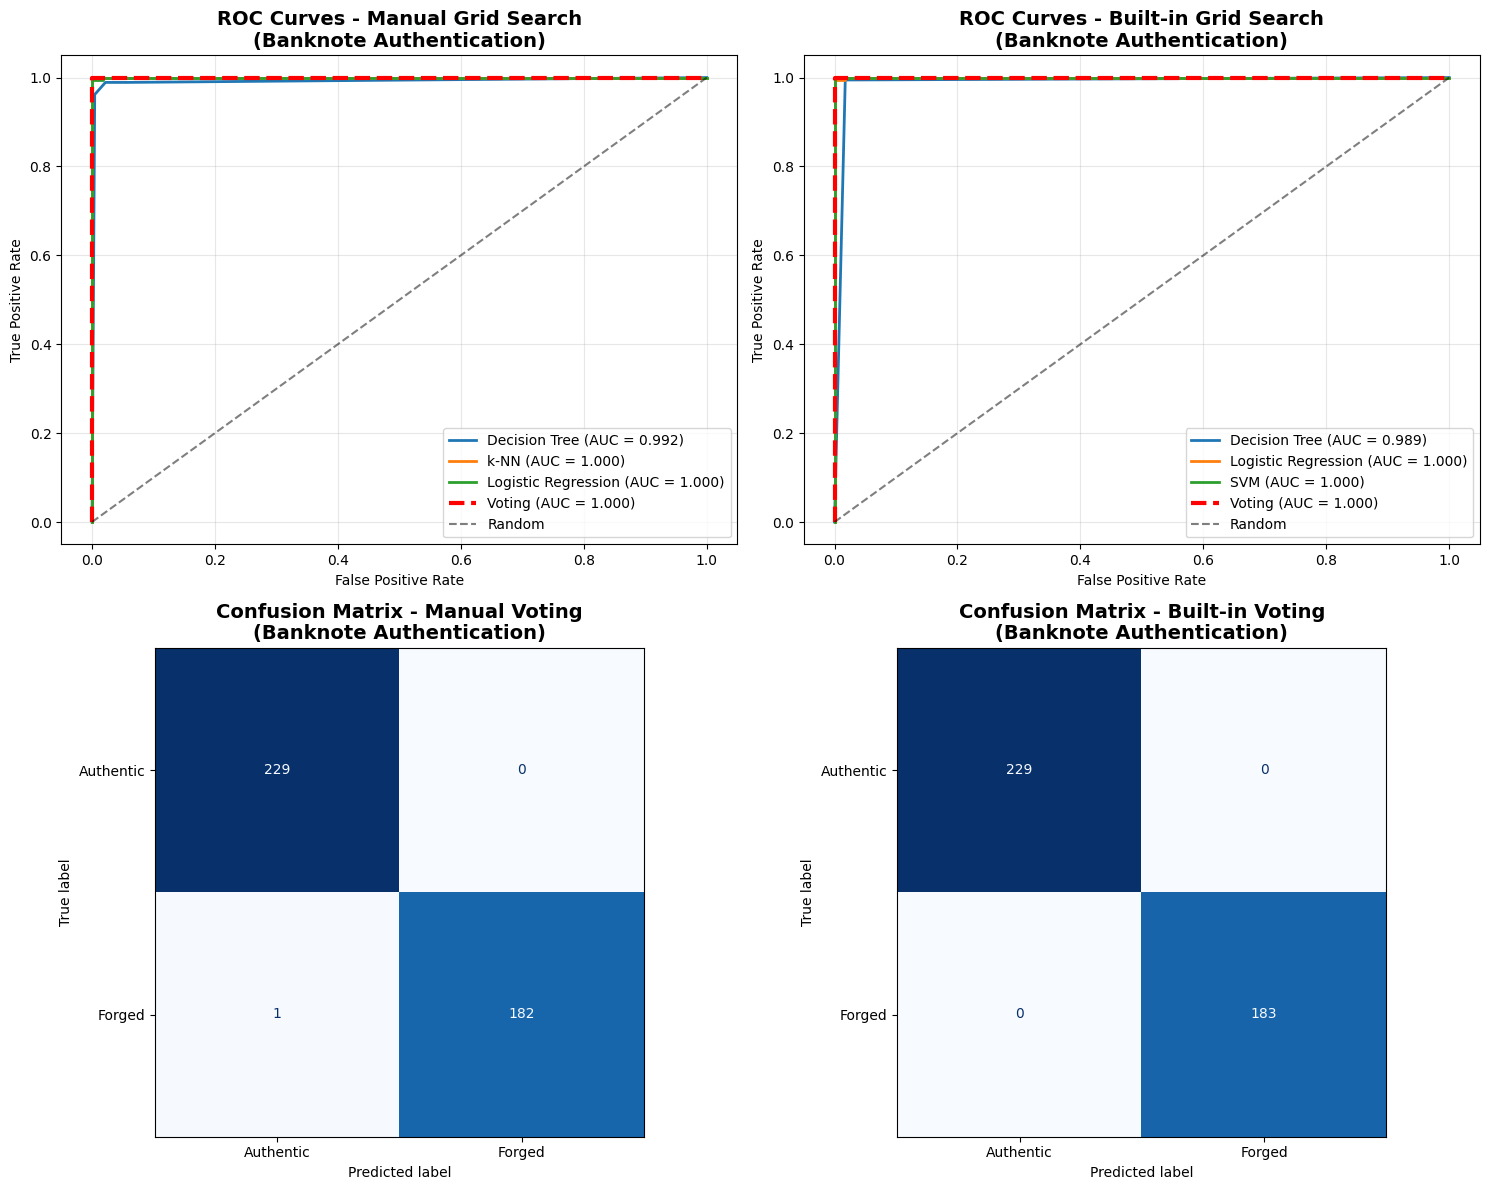

✓ Visualizations created successfully!


In [32]:
# =============================================================================
# CELL 11: Visualizations - ROC Curves and Confusion Matrices
# =============================================================================

print("\nCREATING VISUALIZATIONS")
print("="*60)

# Create comprehensive visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Manual Method ROC Curves
ax1.set_title('ROC Curves - Manual Grid Search\n(Banknote Authentication)', fontsize=14, fontweight='bold')
for name, model in manual_best_models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    ax1.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})', linewidth=2)

# Add manual voting classifier
fpr_vote, tpr_vote, _ = roc_curve(y_test, manual_proba)
auc_score_vote = roc_auc_score(y_test, manual_proba)
ax1.plot(fpr_vote, tpr_vote, label=f'Voting (AUC = {auc_score_vote:.3f})',
         linewidth=3, linestyle='--', color='red')
ax1.plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.5)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Built-in Method ROC Curves
ax2.set_title('ROC Curves - Built-in Grid Search\n(Banknote Authentication)', fontsize=14, fontweight='bold')
for name, model in builtin_best_models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    ax2.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})', linewidth=2)

fpr_vote, tpr_vote, _ = roc_curve(y_test, builtin_proba)
auc_score_vote = roc_auc_score(y_test, builtin_proba)
ax2.plot(fpr_vote, tpr_vote, label=f'Voting (AUC = {auc_score_vote:.3f})',
         linewidth=3, linestyle='--', color='red')
ax2.plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.5)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Confusion Matrices
cm_manual = confusion_matrix(y_test, manual_votes)
disp_manual = ConfusionMatrixDisplay(confusion_matrix=cm_manual, display_labels=['Authentic', 'Forged'])
disp_manual.plot(ax=ax3, cmap='Blues', colorbar=False)
ax3.set_title('Confusion Matrix - Manual Voting\n(Banknote Authentication)', fontsize=14, fontweight='bold')

cm_builtin = confusion_matrix(y_test, builtin_votes)
disp_builtin = ConfusionMatrixDisplay(confusion_matrix=cm_builtin, display_labels=['Authentic', 'Forged'])
disp_builtin.plot(ax=ax4, cmap='Blues', colorbar=False)
ax4.set_title('Confusion Matrix - Built-in Voting\n(Banknote Authentication)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Visualizations created successfully!")


In [33]:
# =============================================================================
# FINAL REPORT SUMMARY
# =============================================================================

print("\n===== REPORT SUMMARY =====")
print("Both manual and built-in grid search methods were implemented on the Banknote dataset.")
print("\nGenerated outputs:")
print("- Performance comparison table")
print("- ROC curves for all models + voting ensemble")
print("- Confusion matrices for voting classifiers")
print("- Full hyperparameter tuning results")
print("\n✅ Execution complete. Use these outputs directly in your report.")



===== REPORT SUMMARY =====
Both manual and built-in grid search methods were implemented on the Banknote dataset.

Generated outputs:
- Performance comparison table
- ROC curves for all models + voting ensemble
- Confusion matrices for voting classifiers
- Full hyperparameter tuning results

✅ Execution complete. Use these outputs directly in your report.
